In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from matplotlib import pyplot as plt
#from tqdm import tqdm_notebook as tqdm
from torchvision.utils import make_grid
%matplotlib inline
import numpy as np 
import math

In [12]:
DATA_ROOT = '/home/rishabh/Downloads/MNIST/data'
seq_length = 28
inp_size = 28
hidden_size = 10
batch_size = 100
num_layers = 2
num_classes = 10
learning_rate = 0.01
num_epochs =3

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
transform=transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_dataset = torchvision.datasets.MNIST(root = '/home/rishabh/Downloads/MNIST/data',train =True,transform = transform,download = True)
test_dataset = torchvision.datasets.MNIST(root='/home/rishabh/Downloads/MNIST/data',
                                          train=False, 
                                          transform=transform,download = True)



In [6]:
valid_dataset = torchvision.datasets.MNIST(root = '/home/rishabh/Downloads/MNIST/data',train =True,transform = transform,download = True)

In [5]:
num_train = len(train_dataset)
indices = list(range(num_train))
split=int(np.floor(0.2*num_train))

In [6]:
tr_idx,valid_idx = indices[split:],indices[:split]
np.random.seed(0)
np.random.shuffle(indices)
trainsampler = SubsetRandomSampler(tr_idx)
validsampler = SubsetRandomSampler(valid_idx)
trainloader = torch.utils.data.DataLoader(dataset = train_dataset,sampler = trainsampler,batch_size = batch_size,shuffle = False)
testloader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size , shuffle=True)
validloader = torch.utils.data.DataLoader(dataset = train_dataset,sampler = validsampler,batch_size = batch_size,shuffle = False)

In [13]:
class RNN(nn.Module):
    def __init__(self,inp_size,hidden_size,num_layers,num_classes):
        super (RNN,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(inp_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        #self.rnn = nn.RNN(28,128,2)
        
        
        
    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        #input = x
        out,_ = self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:])
        
        return out
    
    

In [14]:
model = RNN(inp_size, hidden_size, num_layers, num_classes).to(device)



In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
def valid_accuracy(validloader,model):
    correct= 0
    total = 0
    tot_loss = 0
    with torch.no_grad():
        for data in validloader:
            images,labels = data
            images = images.reshape(-1, seq_length, inp_size).to(device)
            #print(images.size())
            out = model(images)
            _,predicted = torch.max(out.data,1)
            loss = criterion(out,labels)
            tot_loss = tot_loss+loss.item()
            total=total+labels.size(0)
            #correct = correct+(predicted == labels).sum().item()
    #val_acc = (100*correct/total)
    print('Validation loss:%f '%(tot_loss))
    return (tot_loss)

In [11]:
def test_accuracy(testloader,model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.reshape(-1, seq_length, inp_size).to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = (100 * correct / total)
    print('Accuracy of the network on test set: %d %%' % test_acc)
    return(test_acc)
    

In [15]:
val_loss = [];
test_acc = [];
train_loss = [];
running_loss = 0
tot_step = len(trainloader)
for epoch in range(num_epochs):
    for i ,(images,labels) in enumerate(trainloader):
        images = images.reshape(-1, seq_length, inp_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss = running_loss+loss.item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (i+1) % 60 == 0:
            
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, tot_step, loss.item()))
            train_loss.append((running_loss/60))
            running_loss = 0
            v_loss = valid_accuracy(validloader,model)
            val_loss.append(v_loss)
            print('Finished training')
            t_ac = test_accuracy(testloader,model)
            test_acc.append(t_ac)
       


Epoch [1/3], Step [60/480], Loss: 2.3250
Validation loss:279.075045 
Finished training
Accuracy of the network on test set: 15 %
Epoch [1/3], Step [120/480], Loss: 2.2964
Validation loss:279.075044 
Finished training
Accuracy of the network on test set: 15 %
Epoch [1/3], Step [180/480], Loss: 2.3341
Validation loss:279.075044 
Finished training
Accuracy of the network on test set: 15 %
Epoch [1/3], Step [240/480], Loss: 2.2925
Validation loss:279.075053 
Finished training
Accuracy of the network on test set: 15 %
Epoch [1/3], Step [300/480], Loss: 2.3358
Validation loss:279.075043 
Finished training
Accuracy of the network on test set: 15 %
Epoch [1/3], Step [360/480], Loss: 2.3574
Validation loss:279.075047 
Finished training
Accuracy of the network on test set: 15 %
Epoch [1/3], Step [420/480], Loss: 2.3223
Validation loss:279.075044 
Finished training
Accuracy of the network on test set: 15 %
Epoch [1/3], Step [480/480], Loss: 2.3162
Validation loss:279.075044 
Finished training
Acc

In [18]:
modelroot = ('/home/rishabh/Documents/ATSP assignment3/LSTM-1/model1')
torch.save(model.state_dict(), modelroot)

In [65]:
print(val_loss.shape())

AttributeError: 'list' object has no attribute 'shape'

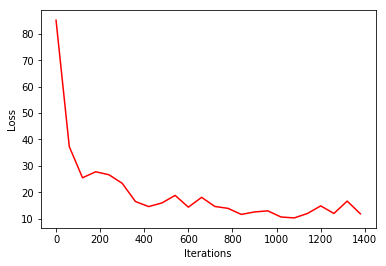

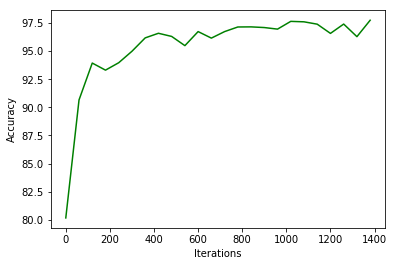

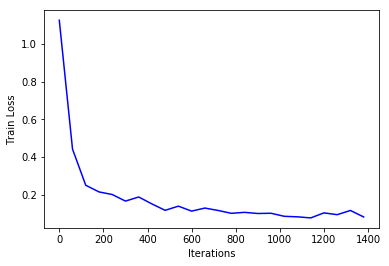

<Figure size 432x288 with 0 Axes>

In [19]:
x=list(range(0,math.floor(480*num_epochs),60))

plt.plot(x,val_loss,'r',label ='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()
plt.plot(x,test_acc,'g',label = 'Test Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

plt.plot(x,train_loss,'b')
plt.xlabel('Iterations')
plt.ylabel('Train Loss')
plt.show()


In [60]:
x=list(range(0,math.floor(480*num_epochs),100))
len(x)


15